In [1]:
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from palettable import wesanderson
import sys
sys.path.insert(0 , './../MAIN/')
from utils import *
import preprocess_functions

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
index_col = 'index'
target = 'paper_BRCA_Subtype_PAM50'

In [10]:
with open(f'./../../data/raw/RPPA_processed.pkl', 'rb') as file:  
    data = pickle.load(file)

In [11]:
datExpr = data['datExpr']
datMeta= data['datMeta']

In [12]:
# Open a new file in binary-write mode
with open('./../../../PNet/PNetTorch/data/RPPA_processed.pkl', 'wb') as file:
    # Use pickle.dump() to write the dictionary to the opened file
    pickle.dump({'datExpr' : datExpr , 'datMeta' : datMeta}, file)


In [13]:
data.keys()

dict_keys(['extracted_feats', 'model', 'datExpr', 'datMeta'])


 Performing SNF for Modality Combinations with 2 modalities 

SNF network for Clinical and RPPA


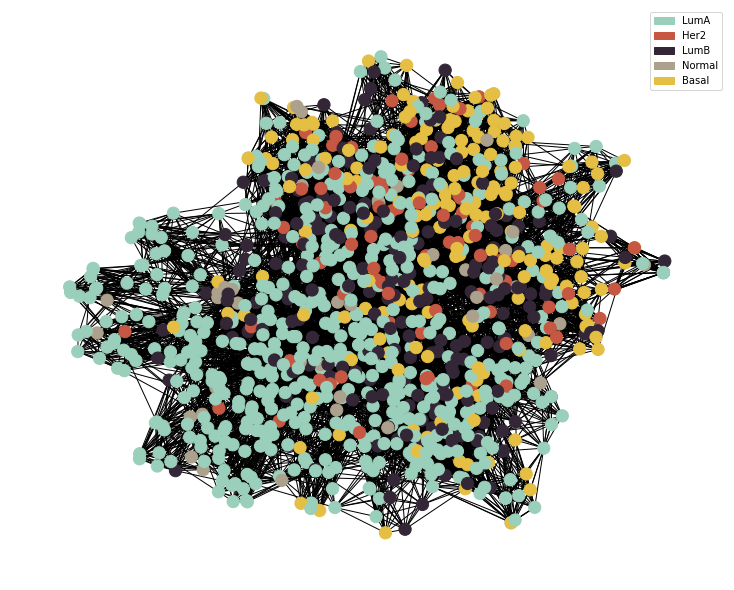

SNF network for Clinical and mRNA


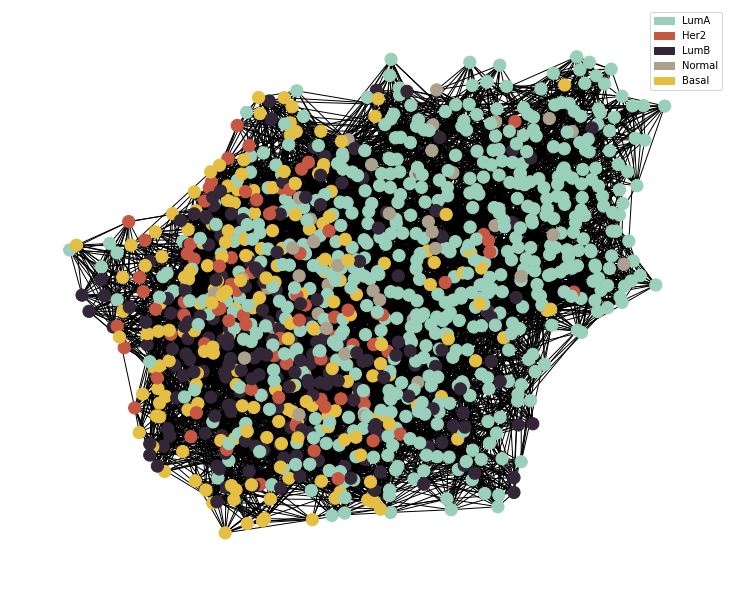

SNF network for RPPA and mRNA


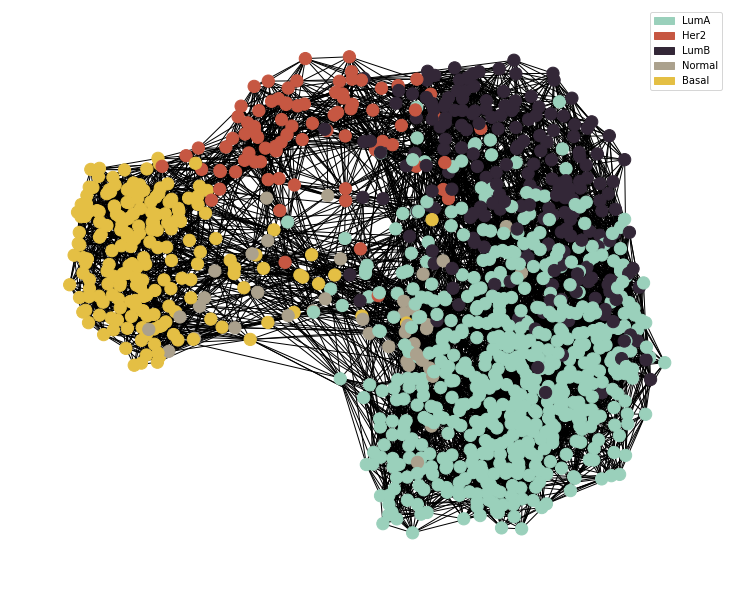


 Performing SNF for Modality Combinations with 3 modalities 

SNF network for Clinical and RPPA and mRNA


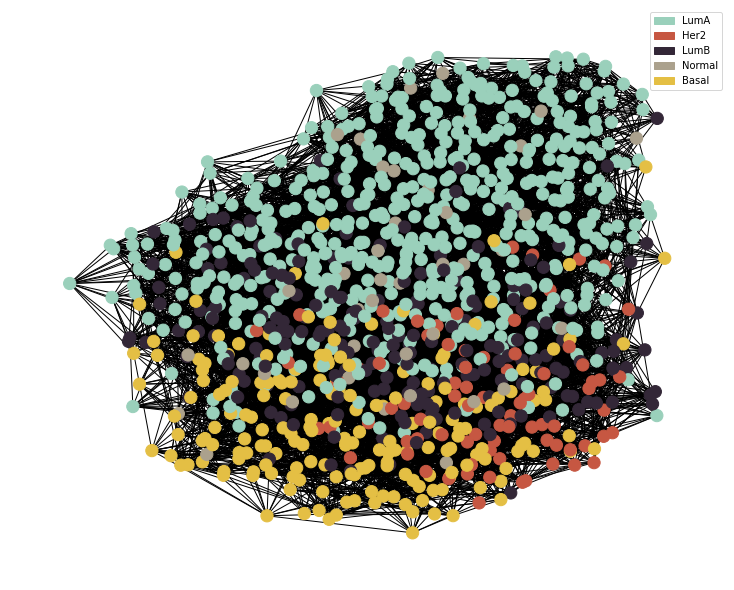

In [8]:
for n_mods in range(2,4) : 
    print(f'\n Performing SNF for Modality Combinations with {n_mods} modalities \n')
    for modalities in itertools.combinations(sorted(['mRNA' ,'RPPA','Clinical' ]) , n_mods) :
        print(f'SNF network for {" and ".join(modalities)}')
        all_graphs = {}
        all_idx = []
        for i , mod in enumerate(modalities) : 
            with open(f'./../../data/raw/{mod}_processed.pkl', 'rb') as file:
                loaded_data = pickle.load(file)

            if i == 0 : 
                datMeta = loaded_data['datMeta'].reset_index()
            else : 
                datMeta = pd.merge(datMeta , loaded_data['datMeta'].reset_index() , how = 'outer'  , on = [index_col , target])

            all_graphs[mod] =  nx.read_graphml(f'./../../data/Networks/{mod}_graph.graphml')
            all_idx.extend(list(all_graphs[mod].nodes))

        datMeta = datMeta.set_index(index_col)
        all_idx = list(set(all_idx))

        full_graphs = []

        for mod , graph in all_graphs.items() : 
            full_graph = pd.DataFrame(data = np.zeros((len(all_idx) , len(all_idx))) , index=sorted(all_idx) , columns=sorted(all_idx))
            graph = nx.to_pandas_adjacency(graph)
            full_graph.loc[graph.index , graph.index] = graph.values

            full_graphs.append(full_graph)

        k = 15
        adj_snf = preprocess_functions.SNF(full_graphs , K=15 , t=10)

        node_labels = pd.Series(adj_snf.index) 

        node_colour = datMeta.loc[adj_snf.index][target].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True)

        G  = preprocess_functions.plot_knn_network(adj_snf , k , datMeta.loc[adj_snf.index][target] ,
                                                               node_colours=node_colour , node_size=150)
        snf_name = '_'.join(modalities)

        nx.write_graphml(G, f'./../../data/Networks/{snf_name}_graph.graphml')

In [ ]:
graph = 'RPPA_mRNA'
G= network_from_csv(f'./../../data/Networks/{graph}_graph.csv' , False)

node_colours = datMeta.loc[list(G.nodes)][target].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True)

labels = datMeta.loc[list(G.nodes)][target]

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=False, font_weight='bold', node_size=150, node_color=node_colours, font_size=8)
patches = []
for col , lab in zip(node_colours.unique() , labels.unique()) : 
    patches.append(mpatches.Patch(color=col, label=lab))
plt.legend(handles=patches)
plt.show()                                            

nx.set_node_attributes(G, labels.astype('category').cat.codes , 'label')

#nx.write_graphml(G, f'./../../data/Networks/{graph}_graph.graphml')

In [ ]:
G_PY = nx.read_graphml(f'./../../data/Networks/RPPA_mRNA_graph.graphml')
node_colours = datMeta.loc[list(G_PY.nodes)][target].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True)

labels = datMeta.loc[list(G_PY.nodes)][target]

plt.figure(figsize=(10, 8))
nx.draw(G_PY, with_labels=False, font_weight='bold', node_size=150, node_color=node_colours, font_size=8)
patches = []
for col , lab in zip(node_colours.unique() , labels.unique()) : 
    patches.append(mpatches.Patch(color=col, label=lab))
plt.legend(handles=patches)
plt.show()  

In [ ]:
node_labels = pd.Series(adj_snf.index) 

node_colour = datMeta.loc[adj_snf.index][target].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True)

G  = preprocess_functions.plot_knn_network(adj_snf , k , datMeta.loc[adj_snf.index][target] ,
                                                       node_colours=node_colour , node_size=150)
snf_name = '_'.join(modalities)

nx.write_graphml(G, f'./../../data/Networks/{snf_name}_graph.graphml')